In [62]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print(f"Pytorch version:[{torch.__version__}]")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"device:[{device}]")

Pytorch version:[1.7.0+cu101]
device:[cuda:0]


In [63]:
from torchvision import datasets, transforms
mnist_train = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

In [64]:
mnist_train, mnist_test

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data/
     Split: Train
     StandardTransform
 Transform: ToTensor(), Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data/
     Split: Test
     StandardTransform
 Transform: ToTensor())

#Data Iterator

In [65]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

#데이터 로더로 불러온 이미지 확인

In [66]:
images, labels = next(iter(test_iter)) # next(iter()) 이 키워드로 256개씩 데이터 불러온다.

In [67]:
print(images.shape)
print(labels.shape)
print(images[0].shape)
print(labels[0].shape)
print(labels[0])

torch.Size([256, 1, 28, 28])
torch.Size([256])
torch.Size([1, 28, 28])
torch.Size([])
tensor(0)


In [68]:
torch_image = torch.squeeze(images[0]) # 제일 바깥 차원 1을 없애준다.
torch_image.shape

torch.Size([28, 28])

In [69]:
image = torch_image.numpy()
image.shape

(28, 28)

In [70]:
label = labels[0].numpy()
print(label.shape) # 스칼라값
print(label)

()
0


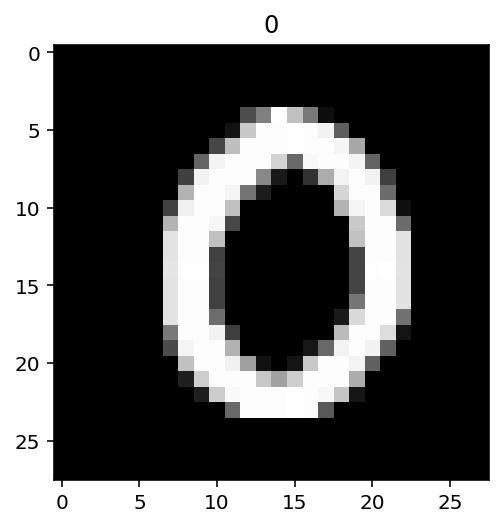

In [71]:
plt.title(label)
plt.imshow(image, 'gray')
plt.show()

#Define Model

In [94]:
class CNN(nn.Module):
    def __init__(self, name='cnn', xdim=[1,28,28], ksize=3,
                 cdims=[32,64], hdims=[1024,128], ydims=10, USE_BATCHNORM=False):
        super(CNN, self).__init__()
        self.name = name
        self.xdim = xdim
        self.ksize = ksize
        self.cdims = cdims
        self.hdims = hdims
        self.ydims = ydims
        self.USE_BATCHNORM = USE_BATCHNORM

        # Convolutional layers 컴포넌트 구성
        self.layers = []
        prev_cdim = self.xdim[0]
        for cdim in self.cdims: # For each hidden layer
            self.layers.append(
                nn.Conv2d(in_channels=prev_cdim,
                          out_channels=cdim,
                          kernel_size=self.ksize,
                          stride=(1,1),
                          padding=self.ksize//2))
            if self.USE_BATCHNORM:
                self.layers.append(nn.BatchNorm2d(cdim)) # batch-norm
            self.layers.append(nn.ReLU(True)) #activation
            self.layers.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))) #max-pooling
            self.layers.append(nn.Dropout2d(p=0.5)) #dropout
            prev_cdim = cdim

        # Dense layers 컴포넌트 구성
        self.layers.append(nn.Flatten())
        prev_hdim = prev_cdim*(self.xdim[1]//(2**len(self.cdims)))*(self.xdim[2]//(2**len(self.cdims)))
        for hdim in self.hdims:
            self.layers.append(nn.Linear(prev_hdim,hdim,bias=True))
            self.layers.append(nn.ReLU(True))
            prev_hdim = hdim
        
        # 위에서 만든 c-layers d-layers 연결
        self.net = nn.Sequential()
        for l_idx, layer in enumerate(self.layers):
            layer_name = f"{type(layer).__name__.lower()}_{l_idx}"
            self.net.add_module(layer_name, layer)
        self.init_param()
    
    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): #init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d): #init BatchNorm
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear): #init dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self,x):
        return self.net(x)

#정의한 모델 간단히 테스트해보기

In [95]:
test = CNN(name='cnn', xdim=[1,28,28], cdims=[32,64], hdims=[1024,128], ydims=10)

In [96]:
test.net

Sequential(
  (conv2d_0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU(inplace=True)
  (maxpool2d_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout2d_3): Dropout2d(p=0.5, inplace=False)
  (conv2d_4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_5): ReLU(inplace=True)
  (maxpool2d_6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout2d_7): Dropout2d(p=0.5, inplace=False)
  (flatten_8): Flatten(start_dim=1, end_dim=-1)
  (linear_9): Linear(in_features=3136, out_features=1024, bias=True)
  (relu_10): ReLU(inplace=True)
  (linear_11): Linear(in_features=1024, out_features=128, bias=True)
  (relu_12): ReLU(inplace=True)
)

In [97]:
test.layers

[Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False),
 Dropout2d(p=0.5, inplace=False),
 Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False),
 Dropout2d(p=0.5, inplace=False),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=3136, out_features=1024, bias=True),
 ReLU(inplace=True),
 Linear(in_features=1024, out_features=128, bias=True),
 ReLU(inplace=True)]

#실제 모델 인스턴스화

In [98]:
C = CNN(name='cnn', xdim=[1,28,28], ksize=3, cdims=[32,64], hdims=[256,128], ydims=10).to(device)

In [99]:
loss = nn.CrossEntropyLoss()
optm = optim.Adam(C.parameters(), lr=1e-3)

#파라미터 체크

In [102]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx, (param_name,param) in enumerate(C.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy() #convert from torch to numpy array
        n_param += len(param_numpy.reshape(-1))
        print(f"{p_idx} name:{param_name} shape:{param_numpy.shape}")
        print(f"   val:{param_numpy.reshape(-1)[:5]}")

print(f"Total number of parameters:{n_param:,d}")

0 name:net.conv2d_0.weight shape:(32, 1, 3, 3)
   val:[ 0.007  1.569 -0.111  0.716 -0.287]
1 name:net.conv2d_0.bias shape:(32,)
   val:[0. 0. 0. 0. 0.]
2 name:net.conv2d_4.weight shape:(64, 32, 3, 3)
   val:[ 0.163  0.098 -0.095 -0.086  0.094]
3 name:net.conv2d_4.bias shape:(64,)
   val:[0. 0. 0. 0. 0.]
4 name:net.linear_9.weight shape:(256, 3136)
   val:[-0.015  0.055  0.015 -0.021  0.033]
5 name:net.linear_9.bias shape:(256,)
   val:[0. 0. 0. 0. 0.]
6 name:net.linear_11.weight shape:(128, 256)
   val:[-0.015 -0.024 -0.014 -0.102 -0.101]
7 name:net.linear_11.bias shape:(128,)
   val:[0. 0. 0. 0. 0.]
Total number of parameters:854,784


Simple Forward Path of the CNN Model

In [105]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(2,1,28,28)
x_torch = torch.from_numpy(x_numpy).float().to(device) # numpy arr to torch tensor
y_torch = C.forward(x_torch)
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy arr
print("x_torch:\n", x_torch)
print("y_torch:\n", x_torch)

x_torch:
 tensor([[[[0.624, 0.522, 0.537,  ..., 0.998, 0.372, 0.063],
          [0.392, 0.312, 0.274,  ..., 0.089, 0.409, 0.772],
          [0.263, 0.171, 0.543,  ..., 0.428, 0.274, 0.060],
          ...,
          [0.811, 0.530, 0.033,  ..., 0.804, 0.586, 0.397],
          [0.997, 0.986, 0.431,  ..., 0.154, 0.076, 0.266],
          [0.401, 0.161, 0.678,  ..., 0.016, 0.748, 0.296]]],


        [[[0.448, 0.538, 0.294,  ..., 0.859, 0.836, 0.576],
          [0.545, 0.260, 0.559,  ..., 0.889, 0.112, 0.513],
          [0.549, 0.313, 0.610,  ..., 0.229, 0.606, 0.189],
          ...,
          [0.320, 0.403, 0.121,  ..., 0.283, 0.389, 0.881],
          [0.209, 0.434, 0.693,  ..., 0.004, 0.047, 0.542],
          [0.624, 0.492, 0.224,  ..., 0.171, 0.228, 0.198]]]], device='cuda:0')
y_torch:
 tensor([[[[0.624, 0.522, 0.537,  ..., 0.998, 0.372, 0.063],
          [0.392, 0.312, 0.274,  ..., 0.089, 0.409, 0.772],
          [0.263, 0.171, 0.543,  ..., 0.428, 0.274, 0.060],
          ...,
          [

In [106]:
x_numpy.shape

(2, 1, 28, 28)

In [107]:
y_numpy.shape

(2, 128)

#Initial Eval

In [115]:
def func_eval(model, data_iter, device):
    with torch.no_grad():
        n_total, n_correct = 0,0
        model.eval() # 모드 체인지. 트레이닝이 아닌 평가 모드라고 지정 evaluate (affects DropOut and BN)
        for batch_in, batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(batch_in.view(-1,1,28,28).to(device))
            _,y_pred = torch.max(model_pred.data,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # 모드 체인지 트레인 모드로
    return val_accr
print("Done")

Done


In [116]:
C.init_param()
train_accr = func_eval(C, train_iter, device)
test_accr = func_eval(C, test_iter, device)

In [117]:
train_accr

0.0031166666666666665

In [120]:
print("start training")
C.init_param()
C.train()
EPOCHS, print_every = 10, 1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in, batch_out in train_iter:
        #Forward Path
        y_pred = C.forward(batch_in.view(-1,1,28,28).to(device))
        loss_out = loss(y_pred, batch_out.to(device))
        #Update
        optm.zero_grad()
        loss_out.backward()
        optm.step()
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)

    if ((epoch%print_every)==0):
        train_accr = func_eval(C, train_iter, device)
        test_accr = func_eval(C, test_iter, device)
        print(f"epoch:{epoch} loss:{loss_val_avg:.3f} train_accr:{train_accr:.3f} test_accr:{test_accr:.3f}")

start training
epoch:0 loss:0.422 train_accr:0.968 test_accr:0.967
epoch:1 loss:0.139 train_accr:0.980 test_accr:0.978
epoch:2 loss:0.097 train_accr:0.985 test_accr:0.982
epoch:3 loss:0.080 train_accr:0.989 test_accr:0.985
epoch:4 loss:0.069 train_accr:0.990 test_accr:0.986
epoch:5 loss:0.062 train_accr:0.993 test_accr:0.988
epoch:6 loss:0.056 train_accr:0.993 test_accr:0.989
epoch:7 loss:0.048 train_accr:0.995 test_accr:0.989
epoch:8 loss:0.045 train_accr:0.995 test_accr:0.990
epoch:9 loss:0.043 train_accr:0.996 test_accr:0.989


#Test

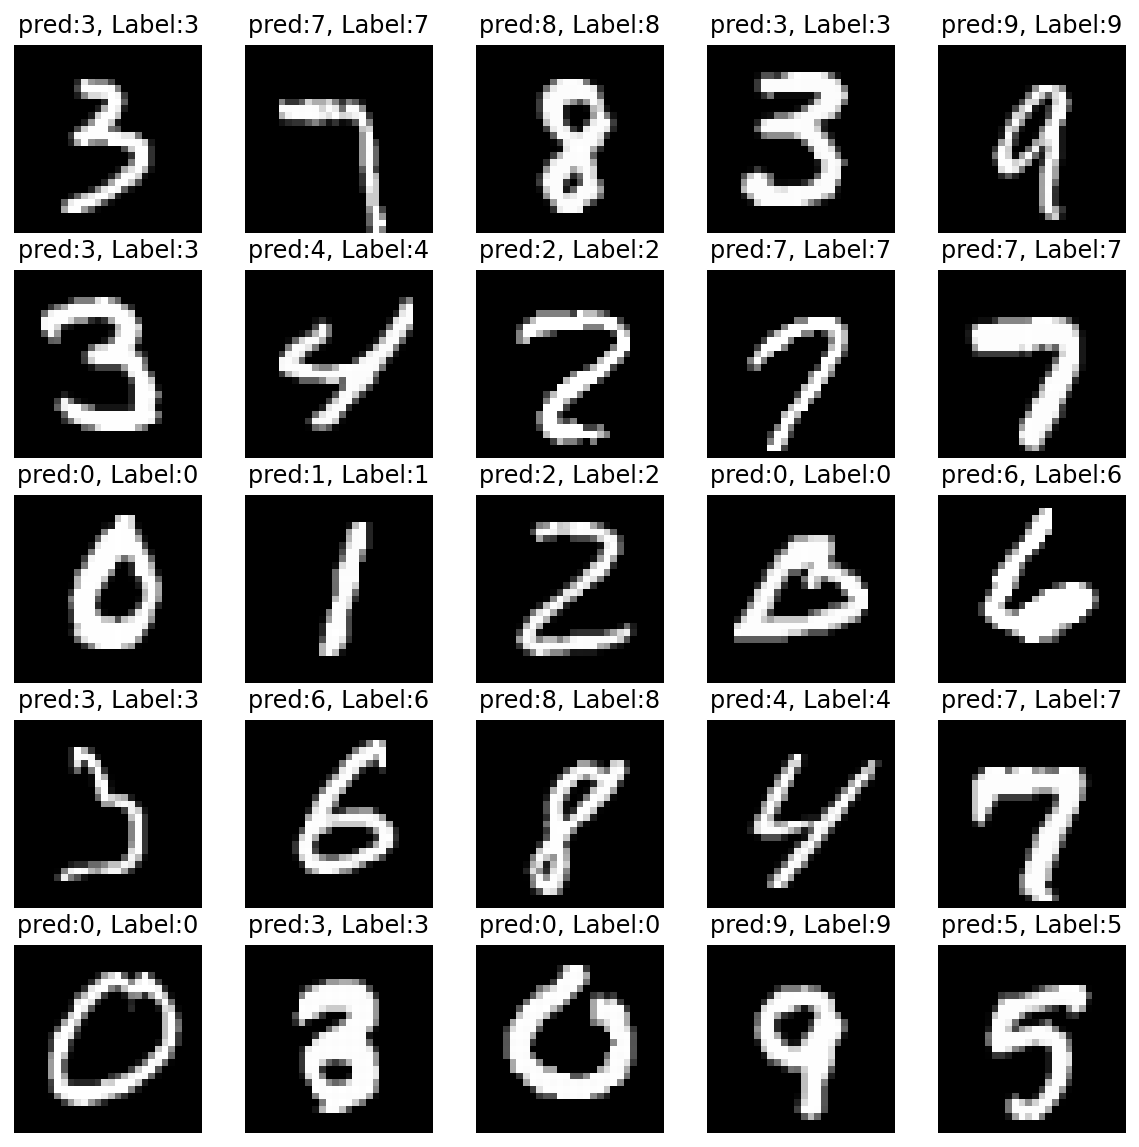

Done


In [121]:
n_sample=25
sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]

with torch.no_grad():
    C.eval() # to evaluation mode
    y_pred = C.forward(test_x.view(-1,1,28,28).type(torch.float).to(device))
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))

for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title(f"pred:{y_pred[idx]}, Label:{test_y[idx]}")

plt.show()
print("Done")